In [425]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime

## Question:1 
### Use the csv provided

In [426]:
df = pd.read_csv("hw2_data.csv", parse_dates = True, index_col = 0)
print (df)

            I_US    I_EU    Inf_US    Inf_EU      Euro
2003-12-01  1.11  2.1590  0.019284  0.021933  1.196501
2004-01-01  1.10  2.1463  0.020352  0.020207  1.258194
2004-02-01  1.06  2.0895  0.020263  0.018343  1.246805
2004-03-01  1.05  2.0706  0.016885  0.016654  1.244803
2004-04-01  1.05  2.0288  0.017401  0.017175  1.236507
...          ...     ...       ...       ...       ...
2022-08-01  2.50  0.0366  0.084821  0.088662  1.020825
2022-09-01  2.76  0.3947  0.082492  0.091406  1.003905
2022-10-01  3.21  1.0109  0.082224  0.099272  0.982956
2022-11-01  3.85  1.4277  0.077631  0.106206  0.988631
2022-12-01  4.46  1.8252  0.071179  0.100546  1.042535

[229 rows x 5 columns]


In [427]:
# Part:a - Interest Rate Differential

In [428]:
# Implement min max scaling in a function
def scale(x):
    return (x-x.min())/(x.max()-x.min())

# Apply Scaling
df["ir_diff"] = scale(df["I_US"]) - scale(df["I_EU"])
df.dropna(inplace= True)
df.tail()

,I_US,I_EU,Inf_US,Inf_EU,Euro,ir_diff
2022-08-01,2.50,0.0366,0.084821,0.088662,1.020825,0.337677
2022-09-01,2.76,0.3947,0.082492,0.091406,1.003905,0.322946
2022-10-01,3.21,1.0109,0.082224,0.099272,0.982956,0.298081
2022-11-01,3.85,1.4277,0.077631,0.106206,0.988631,0.343414
2022-12-01,4.46,1.8252,0.071179,0.100546,1.042535,0.386580


<AxesSubplot:title={'center':'Interest Rate Differential With Scaling'}>

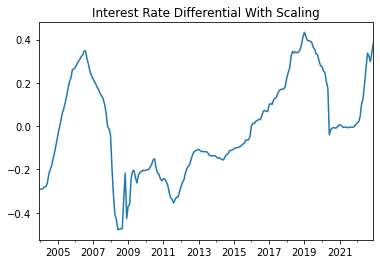

In [429]:
plt.title("Interest Rate Differential With Scaling")
df["ir_diff"].plot()

In [430]:
# Part :b -  Kalman Filter
k = 0.05
w = 5
z = 0.5
df["Filter"] = df.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df["Filter Error"] = df.ir_diff - df["Filter"]

# compute the rolling standard deviation
df["std"] = df["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df["Upper"] = df["Filter"] + z*df["std"]
df["Lower"] = df["Filter"] - z*df["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df["test"] = np.where(df["Filter Error"].abs()>z*df["std"], -1, 0)*np.sign(df["Filter Error"])

In [431]:
df["Filter Error"]

2003-12-01    0.000000
2004-01-01    0.000359
2004-02-01    0.002779
2004-03-01    0.004034
2004-04-01    0.010805
                ...   
2022-08-01    0.224920
2022-09-01    0.199681
2022-10-01    0.166075
2022-11-01    0.200837
2022-12-01    0.231803
Name: Filter Error, Length: 229, dtype: float64

In [343]:
df["test"]

2003-12-01    0.0
2004-01-01    0.0
2004-02-01    0.0
2004-03-01    0.0
2004-04-01   -1.0
             ... 
2022-08-01   -1.0
2022-09-01   -1.0
2022-10-01   -1.0
2022-11-01   -1.0
2022-12-01   -1.0
Name: test, Length: 229, dtype: float64

In [344]:
# PART: C - 409 test
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly dta into the daily data
daily["test"] = df["test"]

daily["Upper"] = df["Upper"]
daily["Lower"] = df["Lower"]
daily["Filter"] = df["Filter"]
daily["ir_diff"] = df["ir_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = daily["ir_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

In [345]:
daily

,test,Upper,Lower,Filter,ir_diff
2003-12-01,0.0,0.000000,0.000000,-0.292402,-0.292402
2003-12-02,0.0,0.000000,0.000000,-0.292402,-0.292402
2003-12-03,0.0,0.000000,0.000000,-0.292402,-0.292402
2003-12-04,0.0,0.000000,0.000000,-0.292402,-0.292402
2003-12-05,0.0,0.000000,0.000000,-0.292402,-0.292402
...,...,...,...,...,...
2022-12-28,0.0,0.167708,0.141846,0.154777,0.386580
2022-12-29,0.0,0.167708,0.141846,0.154777,0.386580
2022-12-30,0.0,0.167708,0.141846,0.154777,0.386580
2022-12-31,0.0,0.167708,0.141846,0.154777,0.386580


In [346]:

i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]       

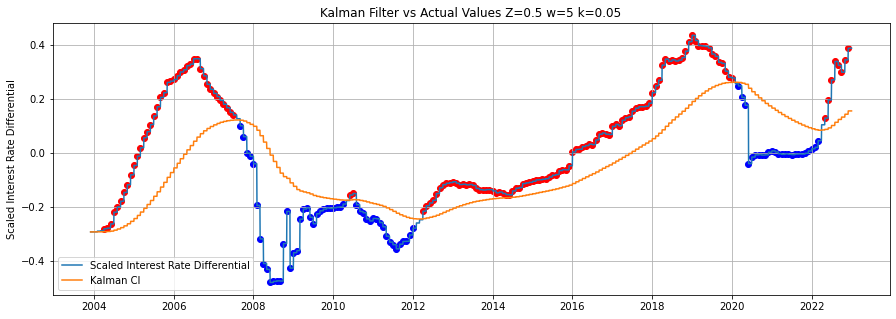

In [347]:
data2 = daily.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [348]:
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = df["Euro"]
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [349]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

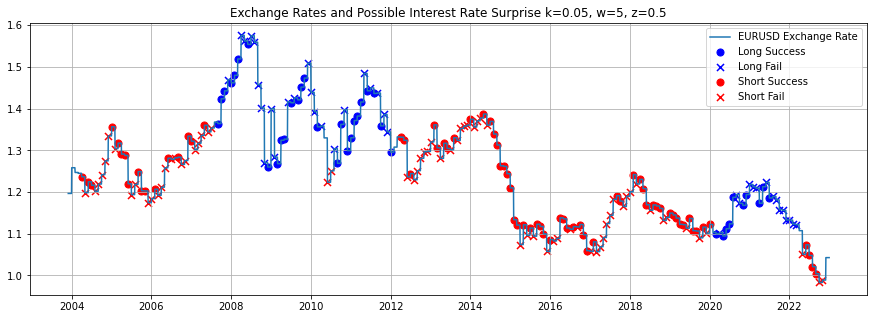

In [350]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

Blue dots represents going LONG
Red dots represents going Short
## Question:2

In [351]:
# Part:a

In [352]:
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = df["Euro"]
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [353]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

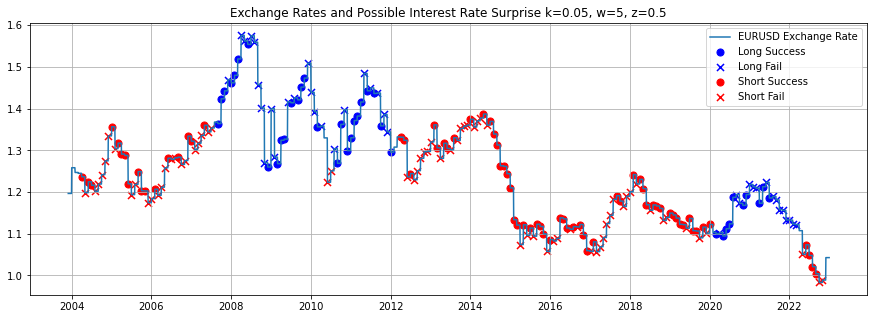

In [354]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

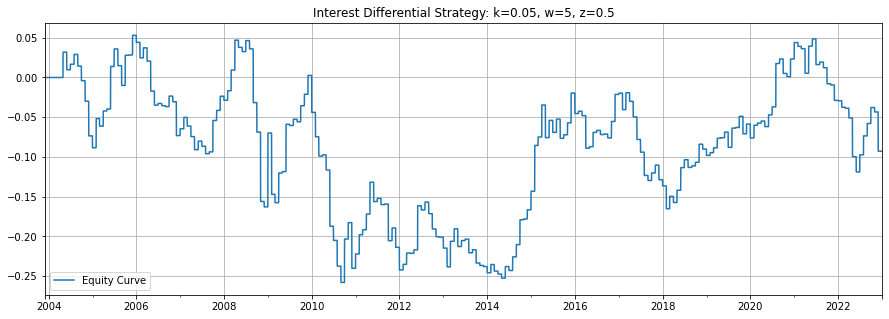

In [355]:
# Part:b - equity curve
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily["171_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

In [356]:
# Part: c - Binomial test, weighted directional test

In [357]:
df = daily[daily.test != 0][["171_signal", "EURUSD"]].copy()
df['D'] = df["171_signal"]

In [358]:
df = df[:-6].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(171))]["EURUSD"].values


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [359]:

df


,171_signal,EURUSD,D,s_current,s_future,R
2004-04-01,-1,1.236507,-1,1.236507,1.219007,-1
2004-05-01,-1,1.198294,-1,1.198294,1.241496,1
2004-06-01,-1,1.224500,-1,1.224500,1.274600,1
2004-07-01,-1,1.216205,-1,1.216205,1.334597,1
2004-08-01,-1,1.201605,-1,1.201605,1.356502,1
...,...,...,...,...,...,...
2022-01-01,1,1.132503,1,1.132503,1.073411,-1
2022-02-01,1,1.122965,1,1.122965,1.047768,-1
2022-03-01,1,1.121592,1,1.121592,1.020825,-1
2022-05-01,-1,1.050420,-1,1.050420,0.982956,-1


In [360]:
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [361]:
T_B

0.006083449051114323

In [362]:
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [363]:
from scipy.stats import norm

In [364]:
statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  0.07130818084231354 , 5 % critical value :  1.64


In [365]:
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [366]:
T_WB

-0.006226444468251974

In [367]:
dy_2 = df['W_2'] - T_WB
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [368]:
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic :' , statistic_2 , ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic : -0.844093261907772 , 5 % critical value :  1.64


In [369]:
# Part: d - differnet variations

In [370]:
# Version with CI
k = 0.1
w = 12
z = 1.02

In [377]:
# This implements the kalman filter in python
# It is simple otherwise to create using a for loop
df["Filter"] = df.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df["Filter Error"] = df.ir_diff - df["Filter"]

# compute the rolling standard deviation
df["std"] = df["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df["Upper"] = df["Filter"] + z*df["std"]
df["Lower"] = df["Filter"] - z*df["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df["test"] = np.where(df["Filter Error"].abs()>z*df["std"], -1, 0)*np.sign(df["Filter Error"])

drange = pd.date_range(start =df.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly dta into the daily data
daily["test"] = df["test"]

daily["Upper"] = df["Upper"]
daily["Lower"] = df["Lower"]
daily["Filter"] = df["Filter"]
daily["ir_diff"] = df["ir_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = daily["ir_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]

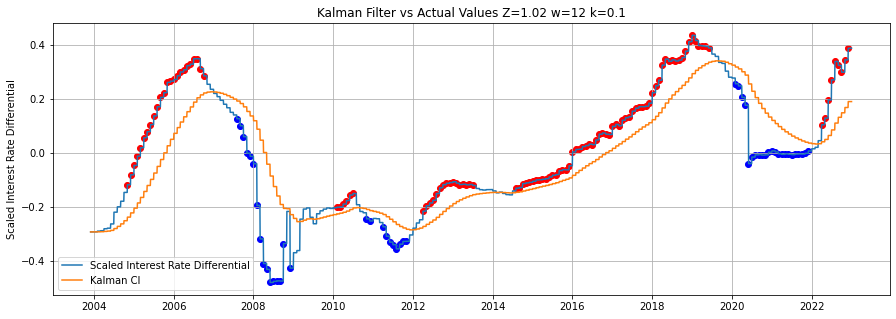

In [378]:
data2 = daily.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [381]:
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = df["Euro"]
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [382]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

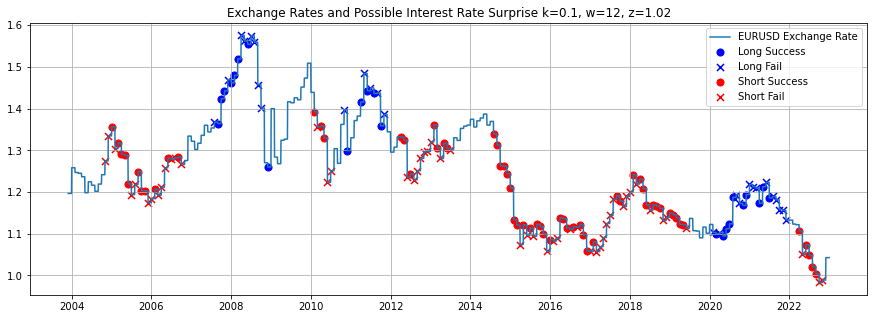

In [383]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

In [384]:
df = daily[daily.test != 0][["171_signal", "EURUSD"]].copy()
df['D'] = df["171_signal"]

In [385]:
df = df[:-6].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(171))]["EURUSD"].values


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [386]:
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [387]:
T_B

0.06442452026451377

In [388]:
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [389]:
from scipy.stats import norm

In [390]:
statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  0.6818611496537675 , 5 % critical value :  1.64


In [391]:
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [392]:
T_WB

-0.000542351394701913

In [393]:
dy_2 = df['W_2'] - T_WB
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [394]:
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic :' , statistic_2 , ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic : -0.06393012218768479 , 5 % critical value :  1.64


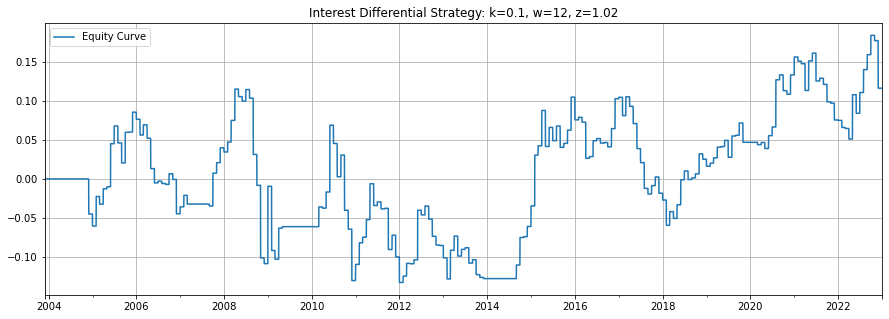

In [395]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily["171_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

2.


In [396]:
k = 0.6
w = 6
z = 1.98

In [405]:

df["Filter"] = df.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df["Filter Error"] = df.ir_diff - df["Filter"]

# compute the rolling standard deviation
df["std"] = df["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df["Upper"] = df["Filter"] + z*df["std"]
df["Lower"] = df["Filter"] - z*df["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df["test"] = np.where(df["Filter Error"].abs()>z*df["std"], -1, 0)*np.sign(df["Filter Error"])

drange = pd.date_range(start =df.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly dta into the daily data
daily["test"] = df["test"]

daily["Upper"] = df["Upper"]
daily["Lower"] = df["Lower"]
daily["Filter"] = df["Filter"]
daily["ir_diff"] = df["ir_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = daily["ir_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]

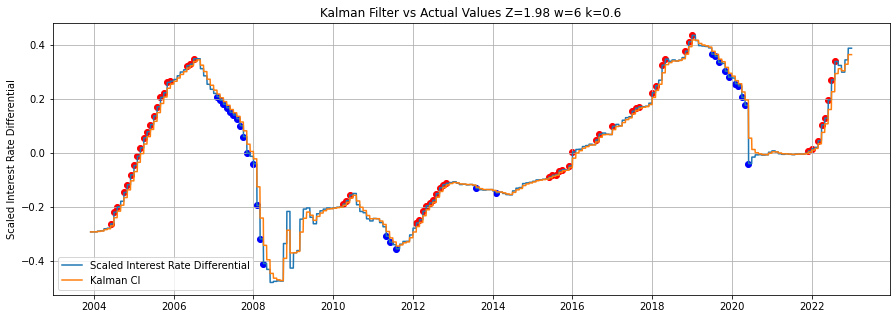

In [406]:
data2 = daily.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [408]:
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = df["Euro"]
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [409]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

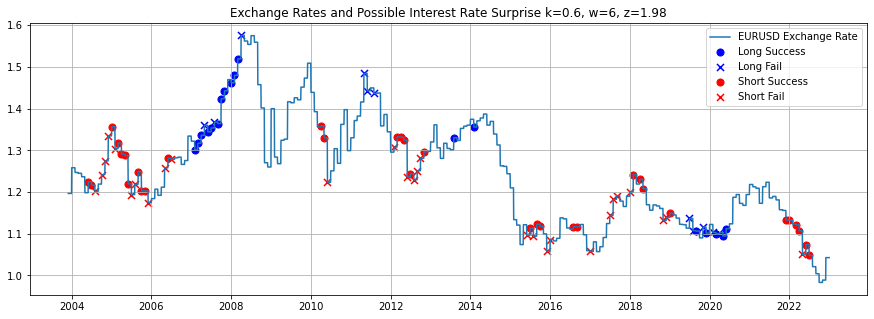

In [410]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

In [411]:
df = daily[daily.test != 0][["171_signal", "EURUSD"]].copy()
df['D'] = df["171_signal"]

In [412]:
df = df[:-6].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(171))]["EURUSD"].values


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [413]:
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [414]:
T_B

0.28179930795847746

In [415]:
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [417]:
statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  2.3825350615086167 , 5 % critical value :  1.64


In [418]:
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [419]:
T_WB

0.015022094109479129

In [420]:
dy_2 = df['W_2'] - T_WB
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [421]:
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic :' , statistic_2 , ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic : 1.5548769680714378 , 5 % critical value :  1.64


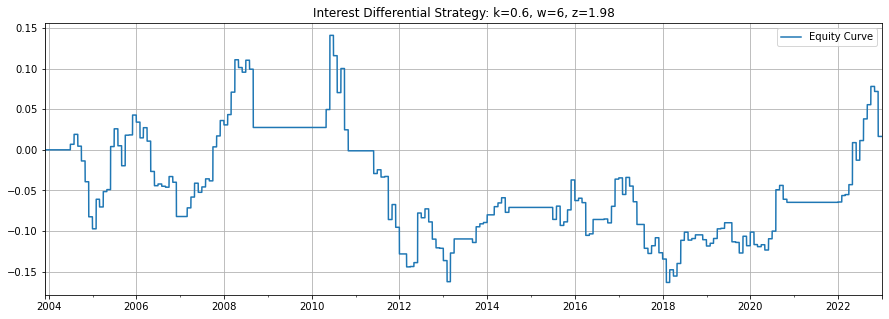

In [422]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily["171_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

3.

In [423]:
k = 0.001
w = 3
z = 1

In [432]:
df["Filter"] = df.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df["Filter Error"] = df.ir_diff - df["Filter"]

# compute the rolling standard deviation
df["std"] = df["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df["Upper"] = df["Filter"] + z*df["std"]
df["Lower"] = df["Filter"] - z*df["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df["test"] = np.where(df["Filter Error"].abs()>z*df["std"], -1, 0)*np.sign(df["Filter Error"])

drange = pd.date_range(start =df.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly dta into the daily data
daily["test"] = df["test"]

daily["Upper"] = df["Upper"]
daily["Lower"] = df["Lower"]
daily["Filter"] = df["Filter"]
daily["ir_diff"] = df["ir_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = daily["ir_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]

In [436]:
df["Filter"] = df.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df["Filter Error"] = df.ir_diff - df["Filter"]

# compute the rolling standard deviation
df["std"] = df["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df["Upper"] = df["Filter"] + z*df["std"]
df["Lower"] = df["Filter"] - z*df["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df["test"] = np.where(df["Filter Error"].abs()>z*df["std"], -1, 0)*np.sign(df["Filter Error"])

drange = pd.date_range(start =df.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly dta into the daily data
daily["test"] = df["test"]

daily["Upper"] = df["Upper"]
daily["Lower"] = df["Lower"]
daily["Filter"] = df["Filter"]
daily["ir_diff"] = df["ir_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = daily["ir_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]

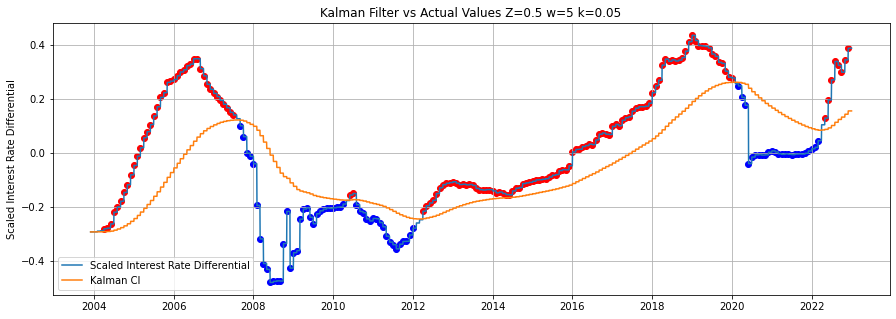

In [437]:
data2 = daily.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [440]:
drange = pd.date_range(start =df.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = df["Euro"]
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [441]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

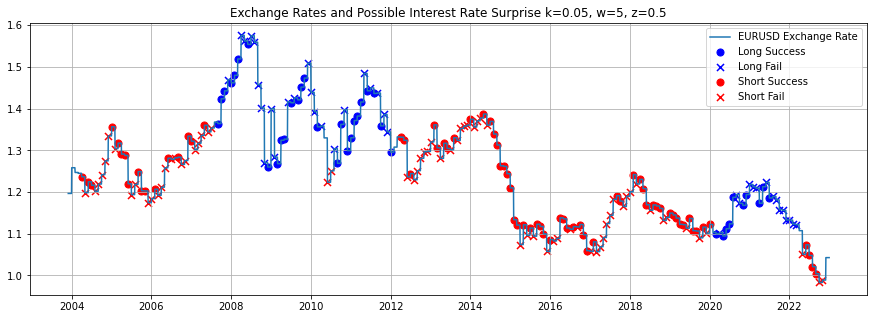

In [442]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["test"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

In [443]:
df = daily[daily.test != 0][["171_signal", "EURUSD"]].copy()
df['D'] = df["171_signal"]

In [444]:
df = df[:-6].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(171))]["EURUSD"].values


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [445]:
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [446]:
T_B

0.006083449051114323

In [447]:
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [448]:
statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  0.07130818084231354 , 5 % critical value :  1.64


In [449]:
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [450]:
T_WB

-0.006226444468251974

In [451]:
dy_2 = df['W_2'] - T_WB
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [452]:
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic :' , statistic_2 , ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic : -0.844093261907772 , 5 % critical value :  1.64


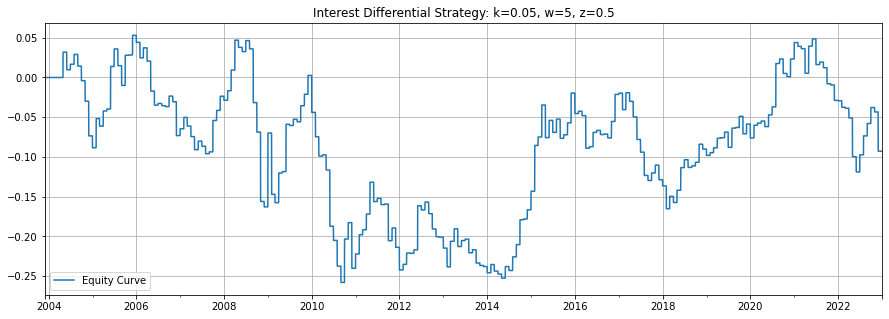

In [453]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily["171_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

## Question:3

In [66]:
# Part: a - Yield to maturity

In [67]:
# current price of the bond = $984.94
# yield to maturity of the bond (10-year interest rate)
from scipy.optimize import root_scalar
face_value = 1000
coupon = 50
n = 10
price = 984.94
y = 0.001
def bond_price(y):
    return sum(coupon / (1 + y)**(t+1) for t in range(n)) + face_value / (1 + y)**n - price
root = root_scalar(bond_price, bracket=[0, 1])
yield_to_maturity = root.root
print('YTM is', yield_to_maturity)

YTM is 0.05196903199509138


In [68]:
#Part b - Price of the bond today

In [69]:
# prob(default) = 0.2, pays nothing
# prob(no default) = 0.8, pays 1000
# bond price today = 0.2(0) + 0.8
# haircut problem: so we have to calculate E(Ft+1) = p.F
p_default = 0.2
expected_f = (1-p_default)*face_value
print("expected value of f is", expected_f)

expected value of f is 800.0


In [70]:
# price of bond is = expected value of / 1 + risk free rate
risk_free = 0.01
price_today = expected_f / (1+risk_free)
print('price of bond today', price_today)

price of bond today 792.0792079207921


## Question:4

In [71]:
# Part:a - Duration of the bond and interpretation

In [72]:
def bond_duration(yield_to_maturity, coupon, n, face_value):
    present_values = [coupon / (1 + yield_to_maturity)**(t+1) for t in range(n)]
    present_values.append(face_value / (1 + yield_to_maturity)**n)
    total_present_value = sum(present_values)
    weighted_times = [t / total_present_value for t, pv in zip(range(n+1), present_values)]
    duration = sum(wt * t for wt, t in zip(weighted_times, range(n+1)))
    return duration
# Bond 1
n1 = 10
coupon1 = 0.15 * 1000
yield_to_maturity1 = 0.1
face_value1 = 1000
duration1 = bond_duration(yield_to_maturity1, coupon1, n1, face_value1)
print("Duration of Bond 1:", duration1)
# Bond 2
n2 = 7
coupon2 = 0.03 * 1000
yield_to_maturity2 = 0.03
face_value2 = 1000
duration2 = bond_duration(yield_to_maturity2, coupon2, n2, face_value2)
print("Duration of Bond 2:", duration2)

Duration of Bond 1: 0.294516255284253
Duration of Bond 2: 0.14


Bond 1 has a higher duration which measn that it is more sensitive to changes in interest rate.


Part:b
Since bond 1 has a higher duration, for a 1% increase in the interest rate, we can expect the priuce to experiene a greater change 


In [74]:
# Part c - DURATION OF A PORTFOLIO
# duration of the portfolio = 30% of 7 year & 70% of 10 year
portfolio_duration = 0.3 * duration2 + 0.7 * duration1
print("Duration of Portfolio:", portfolio_duration)

Duration of Portfolio: 0.24816137869897711


## Question:5

### Part a
The interest rates increased from 2.50%, 2.75% and 2.00% to 3.00%, 3.25% and 2.50%
 
Theimportant changes are:
- the Committee decided to raise the target range for the federal funds rate from 4-4.5% to 4.5-4.75%
- raise the interest rate paid on reserve balances from 4% to 4.65%
- increase in the primary credit rate from 4.5% to 4.75%

### Part b
The interest rate of the US is more than that of the Euro from December 2022 to February 2023
The release of these statements led to a transitory increase in the interest rate differential (US-Euro) at time t (February 2023)

### Part c
This increase in IDR generates the necessary expected appreciation of the Euro between t (Feb 2023) and t+1
The reason is that the market particpants were surprised (public information) and hence they revised their expectations
because of two reasons:
- When the interest rate differential between the US and the euro zone increases, it means that the European Central Bank
(ECB) is offering higher interest rates than the Federal Reserve. This attracts capital from investors seeking higher returns,
which leads to an increased demand for euros and a higher value of the euro relative to other currencies, including the US
dollar.
- Additionally, higher interest rates in the euro zone can lead to an increase in inflation expectations, which further supports the value of the euro.

## Question:6
Investors beleive that the Fed will keep interest rates higher for longer, despite the central bank’s outlook that it is
unlikely to cut rates at all this year.

Thus counter-intutitively, because investors belevie  that the Fed is committed to holding rates higher for longer, that could force the Fed to raise rates more than it otherwise would.

Typically, when the Fed raises interest rates, financial conditions tighten.

The Federal Reserve can facilitate more dialogue with market participants by organizing regular meetings to gain insight into their outlooks and incorporate them into their policy decisions. Additionally, a shift in focus to bank reserve requirements can be included in its press releases, which would affect the amount of money available for lending and consequently help to regulate inflation.